In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
from meshcat.transformations import translation_matrix, rotation_matrix
from meshcat.geometry import Box, MeshPhongMaterial, Cylinder
from scipy.optimize import minimize

### Visualization

In [2]:
# specify a path the the urdf files and meshes
urdf_model_path = "part4.urdf"
mesh_dir = ""

""" 
Initalize parameters for the robot
"""

RADIUS = 0.25  # Radius of the robot (from the URDF)
START = [-2, -2, np.pi/2]  # Starting position of the robot
# START = [-4.25, -2, 0] 
GOAL = [2, 4, 0]  # Goal position of the robot
SEED = 42 # Seed for random number generation
NUMBER_OF_NODES = 1000 # Number of nodes in the graph
NUMBER_OF_NEIGHBORS = 10 # Number of neighbors to consider for each node

# load the robot using pinocchio
robot = pin.RobotWrapper.BuildFromURDF(urdf_model_path, mesh_dir)

# vizualize the robot using meshcat
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(loadModel=True)

def show_robot(x, y, theta, delta):
    quat = pin.Quaternion(pin.utils.rotate('z', theta)).coeffs()
    pos = np.array([x, y, 0.1])
    # Include steering angle (delta) in the configuration vector
    config = np.concatenate([pos, quat, [delta]])
    viz.display(config)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
# Add a floor
# Add floor material
material_floor = MeshPhongMaterial()
material_floor.color = int(200) * 256**2 + int(200) * 256 + int(200)
# Add a floor
viz.viewer["/Floor"].set_object(
    Box([10, 10, 0.01]),
    material_floor
)
viz.viewer["/Floor"].set_transform(
    translation_matrix([0, 0, -0.005])
)

# Add obstacle material
material_obstacle = MeshPhongMaterial()
material_obstacle.color = int(100) * 256**2 + int(100) * 256 + int(100)

# Randomly generate 10 obstacle positions within a defined range
np.random.seed(SEED)
obstacle_positions = [
    np.array([np.random.uniform(-4.8, 4.8), np.random.uniform(-4.8, 4.8), 0.5])
    for _ in range(10)
] # 10 obstacles, defined as x, y, z positions

# add cylinders for each obstacle
for i, pos in enumerate(obstacle_positions):
    viz.viewer[f"/Obstacle_{i}"].set_object(
        Cylinder(1, 0.2), material_obstacle
    )
    T_world_obs = translation_matrix(pos)
    T_world_obs[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Obstacle_{i}"].set_transform(
        T_world_obs
    )

# Add walls between obstacles, for every two obstacles
for i, pos in enumerate(obstacle_positions[::2]):
    # Connect a wall (box) between the two obstacles
    wall_length = np.linalg.norm(obstacle_positions[2*i][:2] - obstacle_positions[2*i+1][:2])
    wall_width = 0.4
    wall_height = 1.0
    wall_material = MeshPhongMaterial()
    wall_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

    wall_position = (obstacle_positions[2*i][:2] + obstacle_positions[2*i+1][:2]) / 2

    viz.viewer[f"/Wall_Obstacle_{i}"].set_object(
        Box([wall_length, wall_width, wall_height]), wall_material
    )
    # Set the wall rotation to align with the line between the two obstacles
    angle = np.arctan2(
        obstacle_positions[2*i+1][1] - obstacle_positions[2*i][1],
        obstacle_positions[2*i+1][0] - obstacle_positions[2*i][0]
    )
    viz.viewer[f"/Wall_Obstacle_{i}"].set_transform(
        translation_matrix([wall_position[0], wall_position[1], wall_height / 2]) @
        rotation_matrix(angle, [0, 0, 1])
    )

# Add walls around the floor
wall_thickness = 0.1
wall_height = 1.0

# Left wall
viz.viewer["/Wall_Left"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Left"].set_transform(
    translation_matrix([-5 - wall_thickness / 2, 0, wall_height / 2])
)

# Right wall
viz.viewer["/Wall_Right"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Right"].set_transform(
    translation_matrix([5 + wall_thickness / 2, 0, wall_height / 2])
)

# Front wall
viz.viewer["/Wall_Front"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Front"].set_transform(
    translation_matrix([0, 5 + wall_thickness / 2, wall_height / 2])
)

# Back wall
viz.viewer["/Wall_Back"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Back"].set_transform(
    translation_matrix([0, -5 - wall_thickness / 2, wall_height / 2])
)

# can you add a tower in each corner of the walls?
tower_height = 1.5
tower_radius = 0.3
tower_material = MeshPhongMaterial()
tower_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

tower_positions = [
    np.array([-5 - wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    # first element is the x position, second is the y position, third is the z position
    np.array([5 + wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    np.array([-5 - wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2]),
    np.array([5 + wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2])
]

for i, pos in enumerate(tower_positions):
    viz.viewer[f"/Tower_{i}"].set_object(
        Cylinder(tower_height, tower_radius), tower_material
    )
    T_world_tower = translation_matrix(pos)
    T_world_tower[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Tower_{i}"].set_transform(
        T_world_tower
    )

In [4]:
x, y, theta = START
# grid is:
# x [-5, 5]
# y [-5, 5]
# theta [0, 2*pi]
show_robot(x,y,theta, 0.0)

### Simulation

In [5]:
WHEELBASE = 0.3  # Distance between front and rear wheels

def discrete_dynamics(state, control_input, dt, model_mismatch=False):
    x, y, theta = state
    v, delta = control_input  # [linear velocity, steering angle]
    L = WHEELBASE

    if model_mismatch:
        v += np.random.normal(0, 0.5)
        delta += np.random.normal(0, 0.1)

    # Bicycle model
    if not np.isclose(delta, 0.0):
        omega = (v / L) * np.tan(delta)
    else:
        omega = 0.0

    x += v * np.cos(theta) * dt
    y += v * np.sin(theta) * dt
    theta += omega * dt

    theta = np.arctan2(np.sin(theta), np.cos(theta))
    return np.array([x, y, theta])


In [6]:
def simulation(controller, mismatch=False):
    # Simulation parameters
    dt = 0.01  # Time step (s)
    simulation_time = 30  # Total simulation time (s)
    sensor_noise_stddev = 0.03  # Standard deviation of sensor noise (m)

    # Initial robot position and orientation
    x, y, theta = START  # Initial position (x, y) and orientation (theta)

    # Simulation loop
    for t in np.arange(0, simulation_time, dt):

        z = np.array([x,y]) + np.random.normal(0, sensor_noise_stddev, 2)  # Simulated sensor measurement with noise

        u, delta = controller(x, y, theta, z)
        x, y, theta = discrete_dynamics([x, y, theta], [u, delta], dt, mismatch)

        # Normalize theta to keep it within [-pi, pi]
        theta = np.arctan2(np.sin(theta), np.cos(theta))

        # Display the robot in the visualization
        show_robot(x, y, theta, delta)
        # Calculate and visualize distances to towers
        
        if np.linalg.norm([x - GOAL[0], y - GOAL[1]]) <= 0.2:
            print("Goal reached!")
            break

        # Pause to simulate real-time visualization
        time.sleep(dt)

# Motion Planning

### Collision Check Function

In [7]:
def get_obstacles():
    """ 
    Obstacles are defined as a list of tuples, where each tuple contains:
    - start point (x, y)
    - end point (x, y)
    - radius (for cylindrical obstacles)
    The obstacles are defined as follows:
    1. Individual cylindrical obstacles (radius = 0.2)
    2. Walls between obstacle pairs (width = 0.4 -> radius = 0.2)
    3. Boundary walls (thickness = 0.1 -> radius = 0.05)
    4. Corner towers (radius = 0.3)
    """
    obstacles = []

    # 1. Individual cylindrical obstacles (radius = 0.2)
    for pos in obstacle_positions:
        x, y = pos[0], pos[1]
        obstacles.append(((x, y), (x, y), 0.2))  # Zero-length capsule (circle)

    # 2. Walls between obstacle pairs (width = 0.4 -> radius = 0.2)
    for i in range(len(obstacle_positions) // 2):
        start_obs = obstacle_positions[2*i]
        end_obs = obstacle_positions[(2*i)+1]
        start = (start_obs[0], start_obs[1])
        end = (end_obs[0], end_obs[1])
        obstacles.append((start, end, 0.2))

    # 3. Boundary walls (thickness = 0.1 -> radius = 0.05)
    obstacles.extend([
        # Left wall (x=-5.05)
        ((-5.05, -5), (-5.05, 5), 0.05),
        # Right wall (x=5.05)
        ((5.05, -5), (5.05, 5), 0.05),
        # Front wall (y=5.05)
        ((-5, 5.05), (5, 5.05), 0.05),
        # Back wall (y=-5.05)
        ((-5, -5.05), (5, -5.05), 0.05)
    ])

    # 4. Corner towers (radius = 0.3)
    for pos in tower_positions:
        x, y = pos[0], pos[1]
        obstacles.append(((x, y), (x, y), 0.3))

    return obstacles

obstacles = get_obstacles()  # Get the list of obstacles

def distance_point_to_segment(p, a, b):
    """ 
    Calculate the distance from point p to the line segment defined by points a and b.
    Parameters:
    - p: Point (x, y) as a numpy array
    - a: Start point of the segment (x, y) as a numpy array
    - b: End point of the segment (x, y) as a numpy array
    Returns:
    - Distance from point p to the segment ab.
    """
    ap = p - a # Vector from a to p
    ab = b - a # Vector from a to b
    t = np.dot(ap, ab) / (np.dot(ab, ab) + 1e-8) # Project p onto line ab
    # 1e-8 is added to avoid division by zero
    t = np.clip(t, 0.0, 1.0) # Clamp projection to the segment [a, b]
    closest = a + t * ab # Closest point on the segment to p
    return np.linalg.norm(p - closest) # Euclidean distance

def is_collision(path, obstacles, robot_radius=RADIUS):
    """ 
    Check if the path collides with any obstacles.
    Parameters:
    - path: List of points representing the path [(x1, y1), (x2, y2), ...]
    - obstacles: List of obstacles, each defined by a tuple (start, end, radius)
                 where start and end are points defining the obstacle segment
                 and radius is the radius of the obstacle.
    - robot_radius: Radius of the robot (default is 1.0)
    Returns:
    - True if the path collides with any obstacle, False otherwise.
    """
    for (x, y) in path:
        for (start, end, radius) in obstacles:
            distance = distance_point_to_segment(np.array([x, y]), np.array(start), np.array(end))
            if distance < (robot_radius + radius):
                return True
    return False

### Optimization-Based Local Planner (Ignoring Obstacles)

In [8]:
from scipy.optimize import minimize

def compute_final_state(start, v, delta, t):
    x0, y0, theta0 = start
    L = WHEELBASE

    if np.isclose(delta, 0.0):
        x = x0 + v * t * np.cos(theta0)
        y = y0 + v * t * np.sin(theta0)
        theta = theta0
    else:
        R = L / np.tan(delta)
        theta = theta0 + (v / R) * t
        x = x0 + R * (np.sin(theta) - np.sin(theta0))
        y = y0 + R * (np.cos(theta0) - np.cos(theta))
    
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    return np.array([x, y, theta])

def local_planner(start, goal, robot_radius=RADIUS):
    def objective(variables):
        v, delta, t = variables  # Now uses steering angle
        final_state = compute_final_state(start, v, delta, t)
        error = final_state[:2] - goal[:2]
        return np.sum(error**2) + 0.1 * t

    # Initial guess and bounds
    dx = goal[0] - start[0]
    dy = goal[1] - start[1]
    distance = np.hypot(dx, dy)
    initial_v = distance / 1.0
    initial_delta = np.arctan(WHEELBASE * (goal[2] - start[2]) / distance) if distance > 0 else 0.0
    initial_guess = [initial_v, initial_delta, 1.0]
    bounds = [(-3.0, 3.0), (-0.6, 0.6), (0.1, 5.0)]  # Steering limits ±0.5 rad

    result = minimize(objective, initial_guess, bounds=bounds, method='SLSQP')
    
    if not result.success:        
        print(f"Local planner failed! Start: {start}, Goal: {goal}")
        return 0.0, 0.0, 0.0, []
    
    v_opt, delta_opt, t_opt = result.x
    dt = 0.1
    time_steps = int(t_opt / dt)
    path = []
    current_state = np.array(start)
    for _ in range(time_steps):
        current_state = discrete_dynamics(current_state, [v_opt, delta_opt], dt, model_mismatch=False)
        path.append(current_state[:2])
    
    if path and not is_collision(path, obstacles, robot_radius):
        return v_opt, delta_opt, t_opt, path
    return 0.0, 0.0, 0.0, []  # Return zero velocities if path collides with obstacles

### PRM

In [9]:
from scipy.spatial import KDTree

class Node:
    """
    Node class for dijkstra search
    """

    def __init__(self, x, y, cost, parent_index):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent_index = parent_index

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," +\
               str(self.cost) + "," + str(self.parent_index)
               
def sample_points(sx, sy, gx, gy, robot_radius, obstacles, rng=None):
    """
    This function samples points in the environment while avoiding obstacles.
    It generates random points within a defined range and checks for collisions
    with obstacles. The function returns a list of sampled points including the
    start and goal positions.
    Parameters:
    - sx: Start x-coordinate
    - sy: Start y-coordinate
    - gx: Goal x-coordinate
    - gy: Goal y-coordinate
    - robot_radius: Radius of the robot
    - obstacles: List of obstacles defined as tuples (start, end, radius)
    - rng: Random number generator (optional)
    Returns:
    - sample_x: List of 500 sampled x-coordinates + [sx, gx]
    - sample_y: List of 500 sampled y-coordinates + [sy, gy]
    """
    min_x, max_x = -5, 5
    min_y, max_y = -5, 5
    sample_x, sample_y = [], []
    rng = np.random.default_rng() if rng is None else rng
    while len(sample_x) < NUMBER_OF_NODES: # number of sample points
        tx = rng.uniform(min_x, max_x)
        ty = rng.uniform(min_y, max_y)
        if not is_collision([(tx, ty)], obstacles, robot_radius+0.2): # add a small margin
            sample_x.append(tx)
            sample_y.append(ty)
    sample_x += [sx, gx]
    sample_y += [sy, gy]
    return sample_x, sample_y

def generate_road_map(sample_x, sample_y, robot_radius, obstacles):
    """
    Generate a road map (graph) from sampled points. (PRM)
    This function creates a road map by connecting sampled points with edges
    based on local planning. It uses a KDTree for efficient nearest neighbor search
    and checks for collisions with obstacles. Each sampled point is connected to
    its nearest neighbors, forming a graph structure.
    Parameters:
    - sample_x: List of sampled x-coordinates
    - sample_y: List of sampled y-coordinates
    - robot_radius: Radius of the robot
    - obstacles: List of obstacles defined as tuples (start, end, radius)
    Returns:
    - road_map: List of edges for each sampled point, where each edge is a list of indices
                of connected points. Each index corresponds to a point in sample_x and sample_y.
    """
    road_map = []
    sample_kd_tree = KDTree(np.vstack((sample_x, sample_y)).T)
    # intialize fast nearest-neighbor lookup from all sample points
    for i in range(len(sample_x)):
        ix, iy = sample_x[i], sample_y[i]
        dists, indexes = sample_kd_tree.query([ix, iy], k=len(sample_x))
        # indexes = indices of all points sorted by distance
        edge_id = []
        for j in indexes[1:]: # skip the first point (itself)
            nx, ny = sample_x[j], sample_y[j]
            start_theta = np.arctan2(ny - iy, nx - ix) # angle to the point
            goal_theta = start_theta # orientation of the robot
            start = [ix, iy, start_theta]
            goal = [nx, ny, goal_theta]
            _, _, _, path = local_planner(start, goal, robot_radius)
            if path and not is_collision(path, obstacles, robot_radius):
                edge_id.append(j)
            if len(edge_id) >= NUMBER_OF_NEIGHBORS:
                break
        road_map.append(edge_id)
    return road_map

def dijkstra_planning(sx, sy, gx, gy, road_map, sample_x, sample_y):
    """ 
    Dijkstra's algorithm for path planning.
    This function implements Dijkstra's algorithm to find the shortest path
    from the start node to the goal node in a road map. It uses a priority queue
    to explore nodes based on their cost and maintains a closed set of visited nodes.
    Parameters:
    - sx: Start x-coordinate
    - sy: Start y-coordinate
    - gx: Goal x-coordinate
    - gy: Goal y-coordinate
    - road_map: List of edges for each sampled point, where each edge is a list of indices
    - sample_x: List of sampled x-coordinates
    - sample_y: List of sampled y-coordinates
    Returns:
    - rx: List of x-coordinates of the path from start to goal
    - ry: List of y-coordinates of the path from start to goal
    """
    start_node = Node(sx, sy, 0.0, -1) # x, y, cost, parent_index
    goal_node = Node(gx, gy, 0.0, -1)
    # open = unvisited nodes, closed = visited nodes
    open_set, closed_set = {len(sample_x)-2: start_node}, {} # start node and empty closed set
    
    # Continue until all reachable nodes are visited or goal is found
    while open_set:
        c_id = min(open_set, key=lambda k: open_set[k].cost)
        current = open_set[c_id]
        if c_id == len(sample_x)-1:
            rx, ry = [current.x], [current.y]
            while current.parent_index != -1:
                current = closed_set[current.parent_index]
                rx.append(current.x)
                ry.append(current.y)
            return rx[::-1], ry[::-1]
        del open_set[c_id] # remove current node from open set
        closed_set[c_id] = current # add current node to closed set
        for n_id in road_map[c_id]: # iterate over neighbors
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = np.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id], current.cost + d, c_id)
            if n_id in closed_set:
                continue
            if n_id in open_set:
                if open_set[n_id].cost > node.cost:
                    open_set[n_id] = node
            else:
                open_set[n_id] = node
    return [], []

# Full motion planner

/home/thibault/miniconda3/envs/py13roboticscourse/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/thibault/miniconda3/envs/py13roboticscourse/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/home/thibault/miniconda3/envs/py13roboticscourse/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


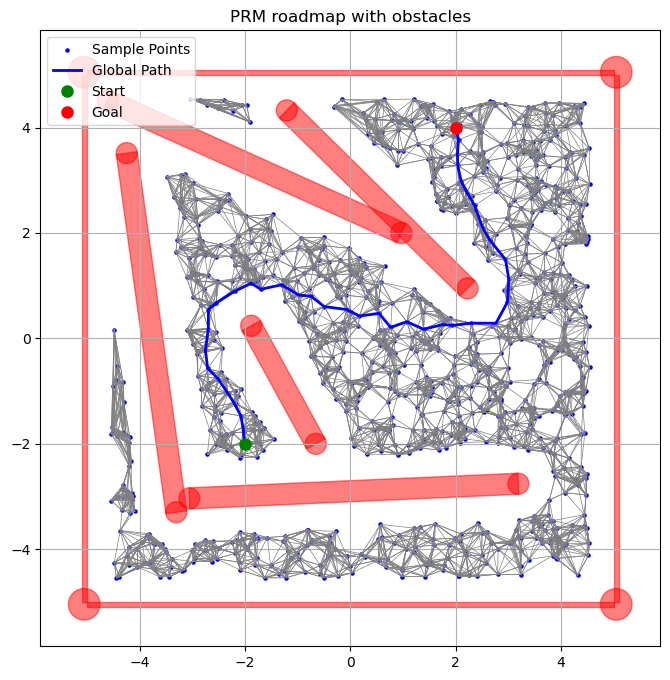

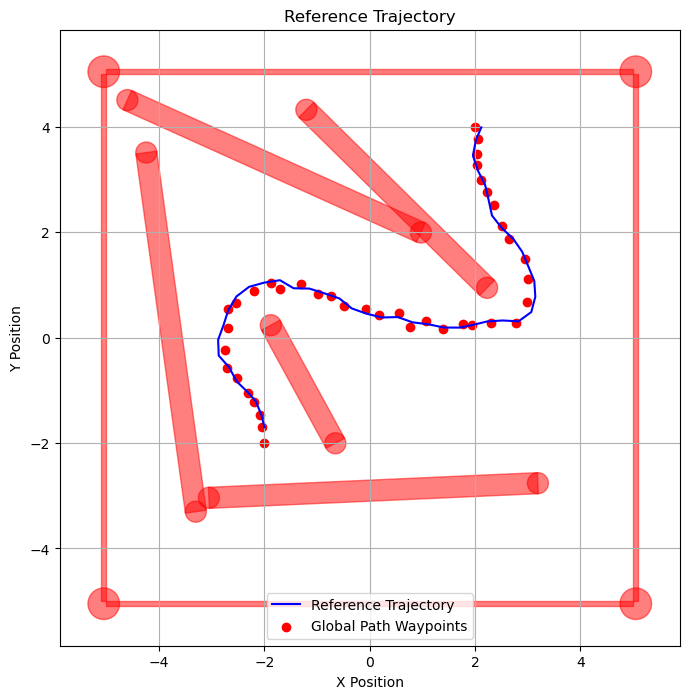

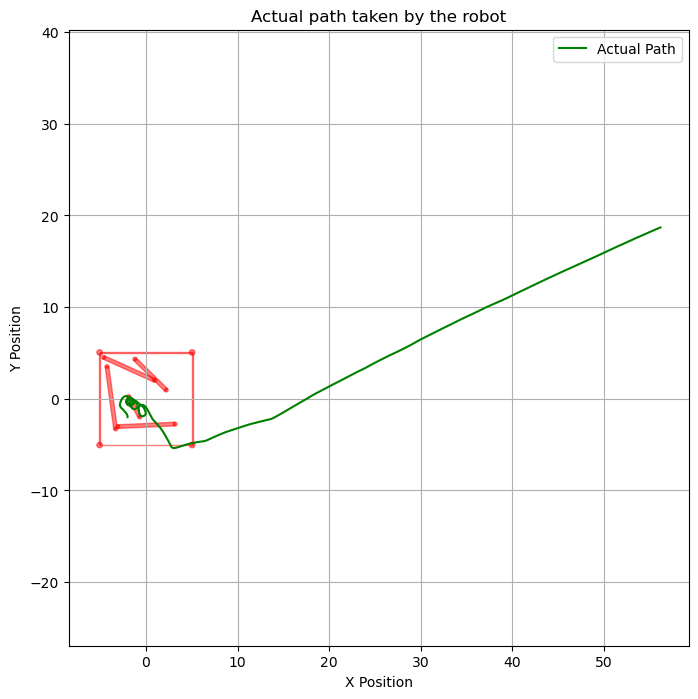

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import matplotlib.transforms as transforms

class MotionPlanner:
    def __init__(self, start, goal, obstacles):
        self.obstacles = obstacles
        self.robot_radius = RADIUS
        self.sample_x, self.sample_y = sample_points(start[0], start[1], goal[0], goal[1], self.robot_radius, obstacles)
        self.road_map = generate_road_map(self.sample_x, self.sample_y, self.robot_radius, obstacles)
        self.global_path_x, self.global_path_y = dijkstra_planning(start[0], start[1], goal[0], goal[1], self.road_map, self.sample_x, self.sample_y)
        self.current_idx = 0
        
        self.ref_traj = None
        self.ref_traj = self.reference_trajectory()
        self.ref_idx = 0
        self.start_time = None  # Initialize start time for reference trajectory
        self.wheelbase = WHEELBASE
        
        self.actual_path_x = [(start[0], start[1])]

    def basic_control(self, x, y, theta):
        """
        Returns the control inputs (linear and angular velocities) for the robot
        to follow the global path towards the next waypoint.
        If the robot is close enough to the next waypoint, it moves to the next one.
        Parameters:
        - x: Current x position of the robot
        - y: Current y position of the robot
        - theta: Current orientation of the robot (in radians)
        Returns:
        - v: Linear velocity to apply
        - delta: Steering angle
        """
        if self.current_idx >= len(self.global_path_x) - 1:
            return 0.0, 0.0
        self.actual_path_x.append((x, y))
        if np.linalg.norm([x - self.global_path_x[-1], y - self.global_path_y[-1]]) < 0.15:
            # print("Reached the goal! Stopping.")
            return 0.0, 0.0
        
        target_x = self.global_path_x[self.current_idx + 1]
        target_y = self.global_path_y[self.current_idx + 1]    

        start = [x, y, theta]
        goal_theta = np.arctan2(target_y - y, target_x - x)
        goal = [target_x, target_y, goal_theta] 
        
        # try to find a valid path using local planner (there exist one but sometimes it generates a collision)
        v, delta, _, path = local_planner(start, goal, self.robot_radius)
        i = 0
        while (path and is_collision(path, self.obstacles, self.robot_radius)) and (i < 10):
            i += 1
            v, delta, _, path = local_planner(start, goal, robot_radius=RADIUS)
        
        if v is None or delta is None:
            print("Invalid control (None detected)! Using zeros.")            
            return 0.0, 0.0  # Stop the robot
        if np.hypot(target_x - x, target_y - y) < 0.3:  # If close enough to the next waypoint
            # if not (self.current_idx + 2 < len(self.global_path_x)):
            #     # print("Reached the goal waypoint! Stopping.")
            # else:
                # print(f"Reached waypoint {self.current_idx}. Advancing to next.")
                # print(f"Current location: ({x:.2f}, {y:.2f}). Next goal location: ({self.global_path_x[self.current_idx + 2]:.2f}, {self.global_path_y[self.current_idx + 2]:.2f})")
                
            self.current_idx += 1
        return v, delta
    
    def reference_trajectory(self):
        """ 
        Generates a full reference trajectory using local planner between consecutive waypoints
        Returns list of (x, y, theta, t) states with timestamps
        """
        if self.ref_traj is not None:
            return self.ref_traj
        
        full_trajectory = []
        current_time = 0.0
        current_state = np.array([self.global_path_x[0], self.global_path_y[0], START[2]])  # Initial orientation
        
        # Create trajectory for each segment of the global path
        for i in range(len(self.global_path_x)-1):
            start = current_state.copy()
            goal_theta = np.arctan2(self.global_path_y[i+1] - start[1], 
                                   self.global_path_x[i+1] - start[0])
            goal = [self.global_path_x[i+1], self.global_path_y[i+1], goal_theta]
            
            # Get local path from planner
            v, delta, t, path = local_planner(start, goal, self.robot_radius) 
            j = 0
            while (path and is_collision(path, self.obstacles, self.robot_radius)) and (j < 10):
                j += 1
                theta_inverse = np.arctan2(np.sin(theta+(j* np.pi/2)), np.cos(theta+ (j*np.pi/2)))
                v, delta, t, path = local_planner(start, goal, robot_radius=RADIUS)
            
            if len(path) == 0:
                continue
                
            # Simulate trajectory with timestamps
            dt = 0.1
            time_steps = int(t / dt)
            current_state_sim = start.copy()
            for _ in range(time_steps):
                current_state_sim = discrete_dynamics(current_state_sim, [v, delta], dt, model_mismatch=False)
                full_trajectory.append({
                    'x': current_state_sim[0],
                    'y': current_state_sim[1],
                    'theta': current_state_sim[2],
                    't': current_time,
                    'v': v,
                    'delta': delta
                })
                current_time += dt
            
            current_state = current_state_sim.copy()
        
        self.ref_traj = full_trajectory
        return full_trajectory
    
    def plot_ref_traj(self):
        """
        Plots the reference trajectory generated by the reference_trajectory method.
        """
        if self.ref_traj is None:
            print("Reference trajectory not generated yet.")
            return
        
        plt.figure(figsize=(8, 8))
        plt.axis("equal")
        
        # Extract x, y, theta from the reference trajectory
        x = [state['x'] for state in self.ref_traj]
        y = [state['y'] for state in self.ref_traj]
        
        plt.plot(x, y, label="Reference Trajectory", color='blue')
        plt.scatter(self.global_path_x, self.global_path_y, color='red', label="Global Path Waypoints")
        
        # Plot obstacles
        for (start, end, radius) in self.obstacles:
            if start == end:  # Circle (cylinder or tower)
                circle = Circle(start, radius, color="red", alpha=0.5)
                plt.gca().add_patch(circle)
            else:
                dx = end[0] - start[0]
                dy = end[1] - start[1]
                length = np.hypot(dx, dy)
                angle = np.arctan2(dy, dx)
                center_x = (start[0] + end[0]) / 2
                center_y = (start[1] + end[1]) / 2

                # Create unrotated rectangle
                box = Rectangle(
                    (-length / 2, -radius),  # lower-left corner (local coords)
                    width=length,
                    height=radius * 2,
                    color="red",
                    alpha=0.5
                )

                # Rotate and move the rectangle to its position
                t = transforms.Affine2D().rotate(angle).translate(center_x, center_y) + plt.gca().transData
                box.set_transform(t)
                plt.gca().add_patch(box)
        
        plt.title("Reference Trajectory")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def reference_trajectory_control(self, x, y, theta):
        # Store actual path
        self.actual_path_x.append((x, y))
        
        # Early exit if near the goal
        if np.linalg.norm([x - GOAL[0], y - GOAL[1]]) < 0.15:
            return 0.0, 0.0

        # Parameters
        k = 2.5                    # Control gain
        k_soft = 1.0               # Softening gain
        max_steer = 0.7            # Steering limit [rad]
        wheelbase = self.wheelbase
        lookahead_distance = 0.05   # Lookahead distance (tune this!)

        # Extract reference path arrays
        path_x = np.array([p['x'] for p in self.ref_traj])
        path_y = np.array([p['y'] for p in self.ref_traj])
        path_yaw = np.array([p['theta'] for p in self.ref_traj])
        path_v = np.array([p['v'] for p in self.ref_traj])

        # Compute front axle position
        fx = x + wheelbase * np.cos(theta)
        fy = y + wheelbase * np.sin(theta)

        # Calculate distances to all points
        dx = path_x - fx
        dy = path_y - fy
        distances = np.hypot(dx, dy)

        # Find the closest point
        closest_idx = np.argmin(distances)
        
        # Find target point: look ahead from closest point
        total_dist = 0.0
        target_index = closest_idx
        for i in range(closest_idx, len(path_x) - 1):
            if total_dist >= lookahead_distance:
                target_index = i
                break
            segment_length = np.hypot(path_x[i+1]-path_x[i], path_y[i+1]-path_y[i])
            total_dist += segment_length

        # Get reference values at target index
        ref_theta = path_yaw[target_index]
        ref_v = path_v[target_index]

        # Yaw error (normalized to [-π, π])
        yaw_error = ((ref_theta - theta) + np.pi) % (2 * np.pi) - np.pi

        # Crosstrack error (lateral deviation)
        vec_x = fx - path_x[target_index]
        vec_y = fy - path_y[target_index]
        crosstrack_error = -vec_x * np.sin(ref_theta) + vec_y * np.cos(ref_theta)

        # Stanley steering law
        crosstrack_steering = np.arctan2(k * crosstrack_error, k_soft + abs(ref_v))
        delta = yaw_error + crosstrack_steering
        
        # Invert steering for reverse
        if ref_v < 0:
            delta = -delta

        delta = np.clip(delta, -max_steer, max_steer)
        return ref_v, delta

    def plot_road_map(self):
        plt.figure(figsize=(8, 8))
        plt.axis("equal")

        # Plot roadmap nodes
        plt.scatter(self.sample_x, self.sample_y, s=5, c="blue", label="Sample Points")

        # Plot roadmap edges
        for i, neighbors in enumerate(self.road_map):
            ix, iy = self.sample_x[i], self.sample_y[i]
            for j in neighbors:
                jx, jy = self.sample_x[j], self.sample_y[j]
                plt.plot([ix, jx], [iy, jy], "gray", linewidth=0.5)

        # Plot obstacles
        for (start, end, radius) in self.obstacles:
            if start == end:  # Circle (cylinder or tower)
                circle = Circle(start, radius, color="red", alpha=0.5)
                plt.gca().add_patch(circle)
            else:
                dx = end[0] - start[0]
                dy = end[1] - start[1]
                length = np.hypot(dx, dy)
                angle = np.arctan2(dy, dx)
                center_x = (start[0] + end[0]) / 2
                center_y = (start[1] + end[1]) / 2

                # Create unrotated rectangle
                box = Rectangle(
                    (-length / 2, -radius),  # lower-left corner (local coords)
                    width=length,
                    height=radius * 2,
                    color="red",
                    alpha=0.5
                )

                # Rotate and move the rectangle to its position
                t = transforms.Affine2D().rotate(angle).translate(center_x, center_y) + plt.gca().transData
                box.set_transform(t)
                plt.gca().add_patch(box)
            
        # Plot global path
        plt.plot(self.global_path_x, self.global_path_y, "b-", linewidth=2, label="Global Path")

        # Plot start and goal
        plt.plot(self.sample_x[-2], self.sample_y[-2], "go", label="Start", markersize=8)
        plt.plot(self.sample_x[-1], self.sample_y[-1], "ro", label="Goal", markersize=8)

        plt.legend()
        plt.title("PRM roadmap with obstacles")
        plt.grid(True)
        plt.show()
        
    def plot_actual_path(self):
        """
        Plots the actual path taken by the robot during the simulation.
        """
        if not self.actual_path_x:
            print("No actual path recorded.")
            return
        
        actual_x, actual_y = zip(*self.actual_path_x)
        
        plt.figure(figsize=(8, 8))
        plt.axis("equal")
        
        # Plot actual path
        plt.plot(actual_x, actual_y, label="Actual Path", color='green')
        
        # Plot obstacles
        for (start, end, radius) in self.obstacles:
            if start == end:  # Circle (cylinder or tower)
                circle = Circle(start, radius, color="red", alpha=0.5)
                plt.gca().add_patch(circle)
            else:
                dx = end[0] - start[0]
                dy = end[1] - start[1]
                length = np.hypot(dx, dy)
                angle = np.arctan2(dy, dx)
                center_x = (start[0] + end[0]) / 2
                center_y = (start[1] + end[1]) / 2

                # Create unrotated rectangle
                box = Rectangle(
                    (-length / 2, -radius), 
                    width=length,
                    height=radius * 2,
                    color="red",
                    alpha=0.5
                )

                # Rotate and move the rectangle to its position
                t = transforms.Affine2D().rotate(angle).translate(center_x, center_y) + plt.gca().transData
                box.set_transform(t)
                plt.gca().add_patch(box)
        
        plt.legend()
        plt.title("Actual path taken by the robot")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.grid(True)
        plt.show()

# Initialize planner with start and goal
start = START
goal = GOAL
obstacles = get_obstacles()
planner = MotionPlanner(start, goal, obstacles)
planner.plot_road_map()
planner.plot_ref_traj()

def controller(x, y, theta, z):
    return planner.reference_trajectory_control(x, y, theta)
    # return planner.basic_control(x, y, theta)


simulation(controller, mismatch=True)

planner.plot_actual_path()

In [11]:
def reference_trajectory_control(self, x, y, theta):
    
    # Store actual path
    self.actual_path_x.append((x, y))
    
    # Early exit if near the goal
    if np.linalg.norm([x - GOAL[0], y - GOAL[1]]) < 0.15:
        return 0.0, 0.0

    # Parameters
    k = 2.5                    # Control gain
    k_soft = 1.0               # Softening gain
    max_steer = 0.7            # Steering limit [rad]
    wheelbase = self.wheelbase

    # Extract reference path arrays
    path_x = np.array([p['x'] for p in self.ref_traj])
    path_y = np.array([p['y'] for p in self.ref_traj])
    path_yaw = np.array([p['theta'] for p in self.ref_traj])
    path_v = np.array([p['v'] for p in self.ref_traj])

    # Compute front axle position
    fx = x + wheelbase * np.cos(theta)
    fy = y + wheelbase * np.sin(theta)

    dx = fx - path_x
    dy = fy - path_y
    d = np.hypot(dx, dy)
    target_index = np.argmin(d)

    # Get reference values at target index
    ref_theta = path_yaw[target_index]
    ref_v = path_v[target_index]

    # Yaw error
    yaw_error = ((ref_theta - theta) + np.pi) % (2 * np.pi) - np.pi

    # Crosstrack error
    vec_x = fx - path_x[target_index]
    vec_y = fy - path_y[target_index]
    crosstrack_error = -vec_x * np.sin(ref_theta) + vec_y * np.cos(ref_theta)

    # Stanley steering law with direction handling
    crosstrack_steering = np.arctan2(k * crosstrack_error, k_soft + abs(ref_v))
    delta = yaw_error + crosstrack_steering
    
    # Invert steering for reverse motion
    if ref_v < 0:
        delta = -delta

    delta = np.clip(delta, -max_steer, max_steer)
    return ref_v, delta

Below you can find the results from the basic control planner. Adjustments to the code and results are discussed after the remaining code.

<div style="width: 100vw; display: flex;">
  <img src="car_like1.png" alt="drawing" style="width: 30%;" />
  <img src="car_like2.png" alt="drawing" style="width: 30%;" />
  <img src="car_like3.png" alt="drawing" style="width: 30%;" />
</div>

Below you can find the results from the reference trajectory planner. Adjustments to the code and results are discussed after the remaining code.

<div style="width: 100vw; display: flex;">
  <img src="car_like1.png" alt="drawing" style="width: 30%;" />
  <img src="car_like2.png" alt="drawing" style="width: 30%;" />
  <img src="car_like3.png" alt="drawing" style="width: 30%;" />
</div>

# Extended Kalman filter

In [12]:
class ExtendedKalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise, measurement_noise):
        self.state = np.array(initial_state)  # [x, y, theta]
        self.covariance = np.array(initial_covariance)  # 3x3 matrix
        self.process_noise = np.array(process_noise)  # Q (3x3)
        self.measurement_noise = np.array(measurement_noise)  # R (2x2)
        self.H = np.array([[1, 0, 0], [0, 1, 0]])  # Measurement matrix

    def predict(self, control_input, dt):
        v, delta = control_input
        x, y, theta = self.state
        L = WHEELBASE

        # Jacobian matrix
        A = np.eye(3)
        A[0, 2] = -v * np.sin(theta) * dt
        A[1, 2] = v * np.cos(theta) * dt

        # Predict state
        self.state = discrete_dynamics(self.state, [v, delta], dt, False)
        self.covariance = A @ self.covariance @ A.T + self.process_noise

    def update(self, measurement):
        """
        Update step using GPS measurement (x, y).
        """
        z = np.array(measurement)
        H = self.H

        # Kalman gain: K = P H^T (H P H^T + R)^-1
        S = H @ self.covariance @ H.T + self.measurement_noise
        K = self.covariance @ H.T @ np.linalg.inv(S)

        # Update state and covariance
        y = z - H @ self.state
        self.state += K @ y
        self.covariance = (np.eye(3) - K @ H) @ self.covariance

    def get_estimate(self):
        return self.state


def simulation_kalman(controller, mismatch=True):
    # Simulation parameters
    u_prev = 0.0
    delta_prev = 0.0
    dt = 0.01  # Time step (s)
    simulation_time = 30  # Total simulation time (s)
    sensor_noise_stddev = 0.03  # Standard deviation of sensor noise (m)

    # Initial robot position and orientation
    x, y, theta = START  # Initial position (x, y) and orientation (theta)
    
    initial_state = [START[0], START[1], START[2]]  # Initial state [x, y, theta]
    initial_covariance = np.diag([0.1, 0.1, 0.1])
    process_noise = np.diag([1.0, 1.0, 0.05])  # Tuned based on model mismatch noise
    measurement_noise = np.diag([0.03**2, 0.03**2])  # From sensor_noise_stddev=0.03
    ekf = ExtendedKalmanFilter(initial_state, initial_covariance, process_noise, measurement_noise)

    # Simulation loop
    for t in np.arange(0, simulation_time, dt):

        z = np.array([x,y]) + np.random.normal(0, sensor_noise_stddev, 2)  # Simulated sensor measurement with noise

        # calculate control inputs
        ekf.predict([u_prev, delta_prev], dt)  # Use previous control for prediction
        ekf.update(z)
        x_est, y_est, theta_est = ekf.get_estimate()
        u, delta = controller(x_est, y_est, theta_est, z)
        u_prev, delta_prev = u, delta  # Store for next prediction

        # Update robot position and orientation using drive kinematics
        x, y, theta = discrete_dynamics([x, y, theta], [u, delta], dt, mismatch)

        # Normalize theta to keep it within [-pi, pi]
        theta = np.arctan2(np.sin(theta), np.cos(theta))

        # Display the robot in the visualization
        show_robot(x, y, theta, delta)
        # Calculate and visualize distances to towers
        
        if np.linalg.norm([x - GOAL[0], y - GOAL[1]]) <= 0.2:
            print("Goal reached!")
            break

        # Pause to simulate real-time visualization
        time.sleep(dt)

# Initialize planner with start and goal
start = START
goal = GOAL
show_robot(START[0], START[1], START[2], 0.0)  # Show initial robot position
obstacles = get_obstacles()
planner = MotionPlanner(start, goal, obstacles)
planner.actual_path_x = [(start[0], start[1])]  # Reset actual path for EKF simulation
planner.plot_road_map()
planner.plot_ref_traj()

def controller(x, y, theta, z):
    return planner.basic_control(x, y, theta)


simulation_kalman(controller, mismatch=True)

planner.plot_actual_path()

KeyboardInterrupt: 

Below you can find the results from the extended Kalman filter. Adjustments to the code and results are discussed below.

<div style="width: 100vw; display: flex;">
  <img src="kalman_car_1.png" alt="drawing" style="width: 30%;" />
  <img src="kalman_car_2.png" alt="drawing" style="width: 30%;" />
  <img src="kalman_car_3.png" alt="drawing" style="width: 30%;" />
</div> 

# Discussion part 4: Car-like robot
To transition from a differential-drive robot to a car-like (bicycle model) robot, several key modifications were needed in the motion planner. Below are the critical changes made and their justifications:

1) Kinematic model: The differential drive kinematics had te be updated to follow the kinematics of the car-like model. The car-like model uses a steering angle $\delta$ instead of an angular velocity $\omega$. A wheelbase L (distance between front and rear axles) was also added, this caused a non-holonomic constraints (no lateral movement). These modifications also constrained the turning radius.

2) The control inputs changed from $u$ and $\omega$ to $u$ and $\delta$. Angular velocity is no longer directly controllable, it followed from the steering geometry.

3) The local planner was adjusted. It now had to optimize $v$, $\delta$ and $t$. 

4) The general control of the robot had to change. It now uses a so called Stanley controller (2). Stanley controllers handle car-like kinematics by combining heading error correction (yaw alignment) and crosstrack error minimization (distance to path).

5) For visualization, the steering angle delta was added to show_robot. 

6) Collision checking remained the same because the dimensions of the robot did not change.

The only significant difference we were able to spot to the actual are that the robot takes less aggresive turns. This will likely have to do with the limited steering angle of the robot. This will however cause the robot the follow a smoother path, which is good.

# References

1) https://medium.com/roboquest/understanding-geometric-path-tracking-algorithms-stanley-controller-25da17bcc219
2) https://github.com/winstxnhdw/FullStanleyController/blob/master/stanley_controller.py